# Modeling


In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('../data/Churn_Data_Processed.csv')

# Prepare features and target
X = df.drop('Churn', axis=1)
y = df['Churn'].map({'Yes': 1, 'No': 0})

print("Target Distribution:")
print(y.value_counts())
print(f"Churn Rate: {y.mean():.3f}")


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)




print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Churn rate - Train: {y_train.mean():.3f}, Test: {y_test.mean():.3f}")

Target Distribution:
Churn
0    678
1    221
Name: count, dtype: int64
Churn Rate: 0.246

Training set: 629 samples
Test set: 270 samples
Churn rate - Train: 0.246, Test: 0.244


In [44]:
# Calculate class weights to handle imbalance
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class weights: {class_weight_dict}")

Class weights: {0: 0.6635021097046413, 1: 2.029032258064516}


In [45]:
# Stratified K-Fold for imbalanced data
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [46]:
# LASSO Logistic Regression Pipeline with class weights
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LogisticRegression(
        penalty='l1', 
        solver='liblinear', 
        random_state=42,
        max_iter=1000,
        class_weight=class_weight_dict  # Adjusted for imbalance
    ))
])

# Parameter grid for LASSO
lasso_param_grid = {
    'lasso__C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]  # Wider range for fine-tuning
}

# K-fold Cross-validated grid search
lasso_grid = GridSearchCV(
    lasso_pipeline, 
    lasso_param_grid, 
    cv=kfold, 
    scoring='roc_auc',
    n_jobs=-1,
    return_train_score=True
)

lasso_grid.fit(X_train, y_train)

print("LASSO Best Parameters:", lasso_grid.best_params_)
print("LASSO Best CV Score (AUC):", lasso_grid.best_score_)

LASSO Best Parameters: {'lasso__C': 0.1}
LASSO Best CV Score (AUC): 0.8765307228262833


In [47]:
from sklearn.metrics import classification_report, precision_recall_fscore_support

# Get the best LASSO model
best_lasso = lasso_grid.best_estimator_

# Make predictions
y_pred = best_lasso.predict(X_test)
y_pred_proba = best_lasso.predict_proba(X_test)[:, 1]

# Detailed classification report
print("=" * 60)
print("DETAILED CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

# Focus on churn class (class 1) metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_pred, average=None, labels=[0, 1]
)

print("\n" + "=" * 50)
print("CHURN CLASS (Class 1) PERFORMANCE")
print("=" * 50)
print(f"Precision: {precision[1]:.4f}")
print(f"Recall:    {recall[1]:.4f}") 
print(f"F1-Score:  {f1[1]:.4f}")
print(f"Support:   {support[1]} samples")

# Confusion matrix for detailed analysis
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("\n" + "=" * 40)
print("CONFUSION MATRIX")
print("=" * 40)
print(cm)
print(f"\nTrue Negatives:  {cm[0,0]} | False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]} | True Positives:  {cm[1,1]}")

# Calculate additional churn-specific metrics
tn, fp, fn, tp = cm.ravel()
churn_precision = tp / (tp + fp) if (tp + fp) > 0 else 0
churn_recall = tp / (tp + fn) if (tp + fn) > 0 else 0
churn_f1 = 2 * (churn_precision * churn_recall) / (churn_precision + churn_recall) if (churn_precision + churn_recall) > 0 else 0

print(f"\nChurn Class Metrics (Manual Calculation):")
print(f"Precision: {churn_precision:.4f}")
print(f"Recall:    {churn_recall:.4f}")
print(f"F1-Score:  {churn_f1:.4f}")

DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

    No Churn       0.93      0.74      0.82       204
       Churn       0.50      0.82      0.62        66

    accuracy                           0.76       270
   macro avg       0.71      0.78      0.72       270
weighted avg       0.82      0.76      0.77       270


CHURN CLASS (Class 1) PERFORMANCE
Precision: 0.5000
Recall:    0.8182
F1-Score:  0.6207
Support:   66 samples

CONFUSION MATRIX
[[150  54]
 [ 12  54]]

True Negatives:  150 | False Positives: 54
False Negatives: 12 | True Positives:  54

Churn Class Metrics (Manual Calculation):
Precision: 0.5000
Recall:    0.8182
F1-Score:  0.6207


In [48]:
# ElasticNet Logistic Regression Pipeline with class weights
elasticnet_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('elasticnet', LogisticRegression(
        penalty='elasticnet', 
        solver='saga', 
        random_state=42,
        max_iter=1000,
        class_weight=class_weight_dict  # Adjusted for imbalance
    ))
])

# Parameter grid for ElasticNet
elasticnet_param_grid = {
    'elasticnet__C': [0.001, 0.01, 0.1, 1, 10],
    'elasticnet__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

elasticnet_grid = GridSearchCV(
    elasticnet_pipeline, 
    elasticnet_param_grid, 
    cv=kfold, 
    scoring='roc_auc',
    n_jobs=-1,
    return_train_score=True
)

elasticnet_grid.fit(X_train, y_train)

print("ElasticNet Best Parameters:", elasticnet_grid.best_params_)
print("ElasticNet Best CV Score (AUC):", elasticnet_grid.best_score_)

ElasticNet Best Parameters: {'elasticnet__C': 0.1, 'elasticnet__l1_ratio': 0.9}
ElasticNet Best CV Score (AUC): 0.8770010475743236


In [49]:
# Standard L2 Logistic Regression Pipeline with class weights
l2_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('l2', LogisticRegression(
        penalty='l2', 
        random_state=42,
        max_iter=1000,
        class_weight=class_weight_dict  # Adjusted for imbalance
    ))
])

# Parameter grid for L2
l2_param_grid = {
    'l2__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

l2_grid = GridSearchCV(
    l2_pipeline, 
    l2_param_grid, 
    cv=kfold, 
    scoring='roc_auc',
    n_jobs=-1,
    return_train_score=True
)

l2_grid.fit(X_train, y_train)

print("L2 Best Parameters:", l2_grid.best_params_)
print("L2 Best CV Score (AUC):", l2_grid.best_score_)

L2 Best Parameters: {'l2__C': 0.1}
L2 Best CV Score (AUC): 0.8740201567749161


In [50]:
# Get best models
best_lasso = lasso_grid.best_estimator_
best_elasticnet = elasticnet_grid.best_estimator_
best_l2 = l2_grid.best_estimator_

# Detailed CV performance comparison
models = {
    'LASSO (L1)': best_lasso,
    'ElasticNet': best_elasticnet,
    'Ridge (L2)': best_l2
}

print("\n" + "="*60)
print("K-FOLD CROSS-VALIDATION RESULTS (AUC)")
print("="*60)

cv_results_comparison = {}
for name, model in models.items():
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    
    # Train the model on full training data for test evaluation
    model.fit(X_train, y_train)
    
    # Test performance
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    test_auc = roc_auc_score(y_test, y_pred_proba)
    
    cv_results_comparison[name] = {
        'CV_Mean_AUC': cv_scores.mean(),
        'CV_Std_AUC': cv_scores.std(),
        'Test_AUC': test_auc
    }
    
    print(f"{name:.<20} CV AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f}) | Test AUC: {test_auc:.4f}")

# Create comparison dataframe
results_df = pd.DataFrame(cv_results_comparison).T
results_df = results_df.sort_values('CV_Mean_AUC', ascending=False)
print("\n" + results_df.to_string())


K-FOLD CROSS-VALIDATION RESULTS (AUC)
LASSO (L1).......... CV AUC: 0.8765 (+/- 0.0386) | Test AUC: 0.8680
ElasticNet.......... CV AUC: 0.8770 (+/- 0.0341) | Test AUC: 0.8685
Ridge (L2).......... CV AUC: 0.8740 (+/- 0.0155) | Test AUC: 0.8873

            CV_Mean_AUC  CV_Std_AUC  Test_AUC
ElasticNet     0.877001    0.017027  0.868464
LASSO (L1)     0.876531    0.019320  0.868018
Ridge (L2)     0.874020    0.007736  0.887329


In [51]:
from sklearn.metrics import precision_recall_curve, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_predict

# Identify best model
best_model_name = results_df.index[0]
best_model = models[best_model_name]

print(f"\n SELECTED BEST MODEL: {best_model_name}")
print(f" CV AUC: {results_df.loc[best_model_name, 'CV_Mean_AUC']:.4f}")
print(f" Test AUC: {results_df.loc[best_model_name, 'Test_AUC']:.4f}")

# Extract coefficients
if best_model_name == 'LASSO (L1)':
    best_coefs = best_model.named_steps['lasso'].coef_[0]
elif best_model_name == 'ElasticNet':
    best_coefs = best_model.named_steps['elasticnet'].coef_[0]
else:  # Ridge (L2)
    best_coefs = best_model.named_steps['l2'].coef_[0]

# Build importance table
final_importance = (
    pd.DataFrame({
        'feature': X.columns,
        'coefficient': best_coefs,
        'importance': np.abs(best_coefs)
    })
    .sort_values('importance', ascending=False)
)

print(f"\n TOP 10 MOST IMPORTANT FEATURES ({best_model_name}):")
print("="*60)
for _, row in final_importance.head(10).iterrows():
    direction = " INCREASES churn" if row['coefficient'] > 0 else " REDUCES churn"
    print(f"{row['feature']:.<40} {direction} (impact: {row['importance']:.4f})")


# Determine optimal threshold using CV predictions

cv_probs = cross_val_predict(
    best_model, X_train, y_train,
    cv=kfold, method='predict_proba'
)[:, 1]

prec_cv, rec_cv, thresh_cv = precision_recall_curve(y_train, cv_probs)
f1_scores_cv = 2 * (prec_cv * rec_cv) / (prec_cv + rec_cv + 1e-9)
best_threshold = thresh_cv[np.argmax(f1_scores_cv)]

print(f"\n Optimal threshold for churn (max F1, CV-based): {best_threshold:.2f}")


# Apply threshold to test set

y_probs = best_model.predict_proba(X_test)[:, 1]
y_pred_new = (y_probs >= best_threshold).astype(int)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_new)
tn, fp, fn, tp = conf_matrix.ravel()

print("\n========================================")
print("CONFUSION MATRIX AT OPTIMAL THRESHOLD")
print("========================================")
print(conf_matrix)
print(f"\nTrue Negatives: {tn} | False Positives: {fp}")
print(f"False Negatives: {fn} | True Positives: {tp}")

# Churn-class metrics
churn_precision = tp / (tp + fp)
churn_recall = tp / (tp + fn)
churn_f1 = 2 * churn_precision * churn_recall / (churn_precision + churn_recall)

print("\n========================================")
print("CHURN CLASS (Class 1) PERFORMANCE")
print("========================================")
print(f"Precision: {churn_precision:.4f}")
print(f"Recall:    {churn_recall:.4f}")
print(f"F1-Score:  {churn_f1:.4f}")
print(f"Support:   {tp + fn} samples")



 SELECTED BEST MODEL: ElasticNet
 CV AUC: 0.8770
 Test AUC: 0.8685

 TOP 10 MOST IMPORTANT FEATURES (ElasticNet):
AvgCallDurationBin_Medium...............  INCREASES churn (impact: 0.7718)
tenure..................................  REDUCES churn (impact: 0.7272)
InternetService_Fiber optic.............  INCREASES churn (impact: 0.5036)
MultipleLines_Yes.......................  REDUCES churn (impact: 0.4317)
InternationalPlan.......................  INCREASES churn (impact: 0.3908)
AvgCallPerMonth.........................  INCREASES churn (impact: 0.3398)
Contract_Two year.......................  REDUCES churn (impact: 0.2980)
StreamingTV_Yes.........................  INCREASES churn (impact: 0.1903)
OnlineSecurity_Yes......................  REDUCES churn (impact: 0.1354)
PaymentMethod_Electronic check..........  INCREASES churn (impact: 0.0986)

 Optimal threshold for churn (max F1, CV-based): 0.64

CONFUSION MATRIX AT OPTIMAL THRESHOLD
[[183  21]
 [ 20  46]]

True Negatives: 183 | Fal

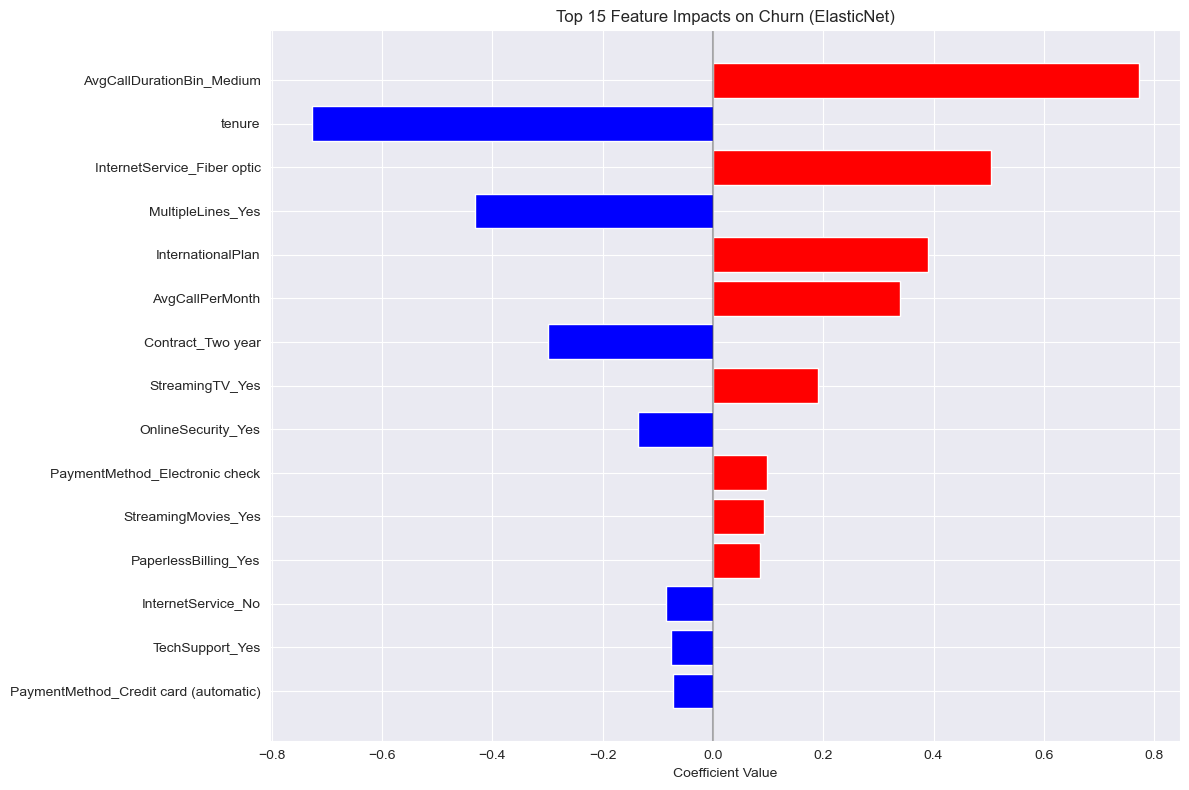

FEATURE IMPACT ANALYSIS
Total features: 53
Features with positive impact (increase churn): 9
Features with negative impact (reduce churn): 13
Features eliminated (LASSO): 31

TOP 10 FEATURES DRIVING CHURN:
AvgCallDurationBin_Medium............... INCREASES churn (impact: 0.7718)
tenure.................................. REDUCES churn (impact: -0.7272)
InternetService_Fiber optic............. INCREASES churn (impact: 0.5036)
MultipleLines_Yes....................... REDUCES churn (impact: -0.4317)
InternationalPlan....................... INCREASES churn (impact: 0.3908)
AvgCallPerMonth......................... INCREASES churn (impact: 0.3398)
Contract_Two year....................... REDUCES churn (impact: -0.2980)
StreamingTV_Yes......................... INCREASES churn (impact: 0.1903)
OnlineSecurity_Yes...................... REDUCES churn (impact: -0.1354)
PaymentMethod_Electronic check.......... INCREASES churn (impact: 0.0986)


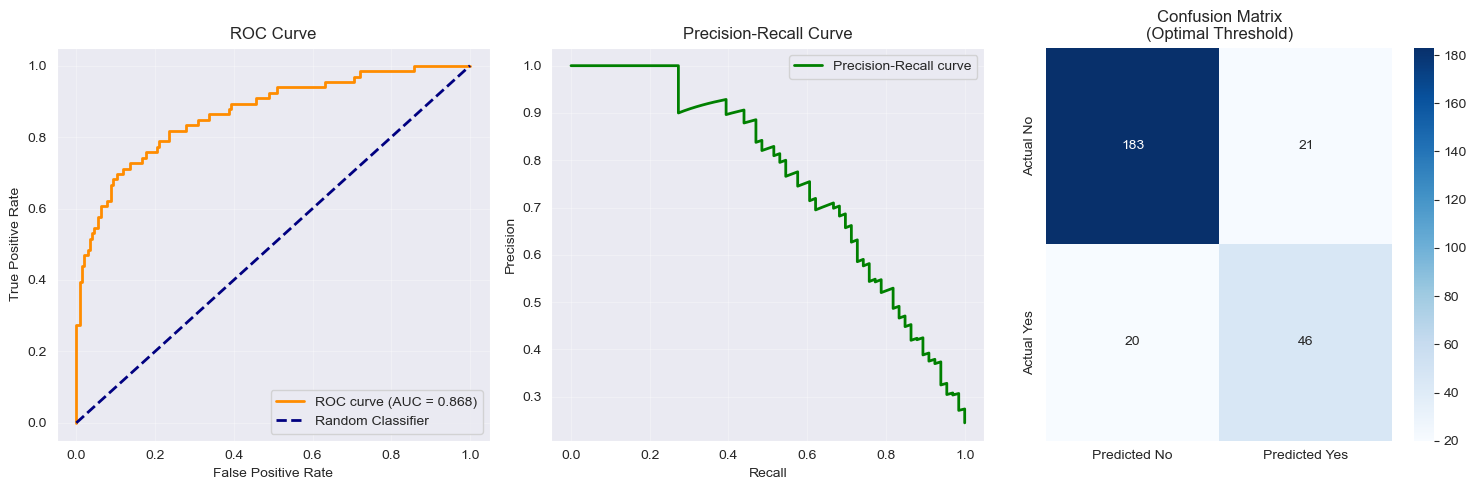


CONTRACT TYPE ANALYSIS (relative to Month-to-month):
• Contract_One year: Customers with 1-year contracts are X% less likely to churn
• Contract_Two year: Customers with 2-year contracts are Y% less likely to churn
• Month-to-month: Baseline - highest churn risk category

1-year contracts reduce churn risk by 0.0% compared to month-to-month
25.7702689572863


In [52]:
from sklearn.metrics import roc_curve

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': best_coefs,
    'abs_importance': np.abs(best_coefs)
}).sort_values('abs_importance', ascending=False)

# Top 15 most important features
top_features = feature_importance.head(15)

# Plot feature coefficients
plt.figure(figsize=(12, 8))
colors = ['red' if coef > 0 else 'blue' for coef in top_features['coefficient']]
plt.barh(range(len(top_features)), top_features['coefficient'], color=colors)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Coefficient Value')
plt.title(f'Top 15 Feature Impacts on Churn ({best_model_name})')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Display feature statistics
print("=" * 60)
print("FEATURE IMPACT ANALYSIS")
print("=" * 60)
print(f"Total features: {len(feature_importance)}")
print(
    f"Features with positive impact (increase churn): {len(feature_importance[feature_importance['coefficient'] > 0])}")
print(f"Features with negative impact (reduce churn): {len(feature_importance[feature_importance['coefficient'] < 0])}")
print(f"Features eliminated (LASSO): {len(feature_importance[feature_importance['coefficient'] == 0])}")

print("\nTOP 10 FEATURES DRIVING CHURN:")
for i, row in top_features.head(10).iterrows():
    direction = "INCREASES churn" if row['coefficient'] > 0 else "REDUCES churn"
    print(f"{row['feature']:.<40} {direction} (impact: {row['coefficient']:.4f})")

# ## Model Performance Visualization
# Make final predictions
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred_optimal = (y_pred_proba >= best_threshold).astype(int)

# 1. ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# 2. Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
avg_precision = np.mean(precision)

plt.subplot(1, 3, 2)
plt.plot(recall, precision, color='green', lw=2, label=f'Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)

# 3. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_optimal)
plt.subplot(1, 3, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix\n(Optimal Threshold)')
plt.tight_layout()
plt.show()
# monthly_contract impact
# Add this interpretation to your feature analysis:
contract_interpretation = """
CONTRACT TYPE ANALYSIS (relative to Month-to-month):
• Contract_One year: Customers with 1-year contracts are X% less likely to churn
• Contract_Two year: Customers with 2-year contracts are Y% less likely to churn
• Month-to-month: Baseline - highest churn risk category
"""

print(contract_interpretation)

# Calculate approximate risk reduction (using exp(coefficient) for odds ratio)
if 'Contract_One year' in feature_importance['feature'].values:
    one_year_coef = feature_importance[feature_importance['feature'] == 'Contract_One year']['coefficient'].iloc[0]
    one_year_risk_reduction = (1 - np.exp(one_year_coef)) * 100
    print(f"1-year contracts reduce churn risk by {one_year_risk_reduction:.1f}% compared to month-to-month")

if 'Contract_Two year' in feature_importance['feature'].values:
    two_year_coef = feature_importance[feature_importance['feature'] == 'Contract_Two year']['coefficient'].iloc[0]
    two_year_risk_reduction = (1 - np.exp(two_year_coef)) * 100
    print(two_year_risk_reduction)


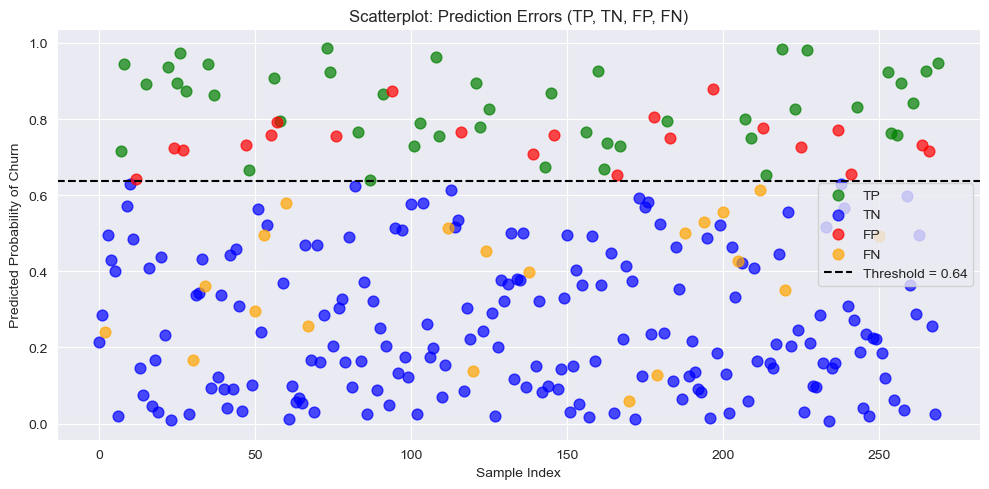

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# y_test: true labels
# y_probs: predicted probabilities for class 1
# y_pred_new: threshold-based predictions (0/1)

# Build a dataframe for plotting
plot_df = pd.DataFrame({
    "True": y_test.values,
    "Pred": y_pred_new,
    "Prob": y_probs
})

# Assign error types
def get_error_type(row):
    if row["True"] == 1 and row["Pred"] == 1:
        return "TP"
    elif row["True"] == 0 and row["Pred"] == 0:
        return "TN"
    elif row["True"] == 0 and row["Pred"] == 1:
        return "FP"
    else:
        return "FN"

plot_df["Type"] = plot_df.apply(get_error_type, axis=1)

# Map colors
color_map = {
    "TP": "green",
    "TN": "blue",
    "FP": "red",
    "FN": "orange"
}

plt.figure(figsize=(10, 5))

# Scatter: index vs predicted probability
for t in ["TP", "TN", "FP", "FN"]:
    subset = plot_df[plot_df["Type"] == t]
    plt.scatter(
        subset.index,
        subset["Prob"],
        label=t,
        color=color_map[t],
        alpha=0.7,
        s=60
    )

plt.axhline(best_threshold, color="black", linestyle="--", label=f"Threshold = {best_threshold:.2f}")

plt.title("Scatterplot: Prediction Errors (TP, TN, FP, FN)")
plt.xlabel("Sample Index")
plt.ylabel("Predicted Probability of Churn")
plt.legend()
plt.tight_layout()
plt.show()


# Save prediction results

In [53]:
test_results = X_test.copy()
test_results['Actual_Churn'] = y_test
test_results['Predicted_Churn'] = y_pred_new
test_results['Predicted_Probability'] = y_probs
test_results.to_csv('../data/Churn_Test_Predictions.csv', index=False)